In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from scipy.io import wavfile
from pydub import AudioSegment, effects
from pydub.silence import split_on_silence
from pathlib import Path

In [2]:
#GraphicMaker
#reads a wav file and plots it
class GraphAudio():
  def readFile(self,path):
    #reads wav file
    self.samplerate, self.data = wavfile.read(path)
    print("new file read: "+path)
    self.times = np.arange(len(self.data))/float(self.samplerate)


  def graph(self):
        plt.figure(figsize=(30, 4))
       # Check if the audio data is mono or stereo
        if self.data.ndim == 1:
            plt.plot(self.times, self.data, color='k')  # Plot for mono audio
        else:
            plt.fill_between(self.times, self.data[:,0], self.data[:,1], color='k')  # Plot for stereo audio
        plt.xlim(self.times[0], self.times[-1])
        plt.xlabel('time (s)')
        plt.show()

In [64]:
# Audio Splitter
# splits a wav file into chunks of audio separated by silence
class SplitWavAudioMubin():
    def __init__(self, folder, folder_export_path, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '/' + filename + ".wav"
        self.folder_export_path = folder_export_path
        print(self.filepath)
        self.audio = AudioSegment.from_wav(self.filepath)

        self.new_metadata=[]

    def get_duration(self):
        return self.audio.duration_seconds

    def split(self, min_len, thresh):
        #splits the audio file
        print("audio to predict: "+self.filepath)
        print("dbfs: "+str(self.audio.dBFS))
        reduced_noise = self.audio.low_pass_filter(5000).high_pass_filter(200)
        audio_normal=reduced_noise.normalize(-20.0)        #normalize audio
        #split
        chunks = split_on_silence(
          #audio to process
          #self.audio,
          reduced_noise,
          #min silence in ms - 1000ms equals 1s
          min_silence_len = min_len, #200 default
          silence_thresh = self.audio.dBFS-thresh, #16 default
          keep_silence = 200, # optional
          )
        print("Number of chunks detected:", len(chunks))
        #export audio
        print("export path:"+self.folder_export_path + '/' + self.filename+"_")
        for i, chunk in enumerate(chunks):
          Path(self.folder_export_path).mkdir(parents=True, exist_ok=True)
          chunk.export(self.folder_export_path + '/' + self.filename+"_"+str(i)+".wav", format="wav")
          self.new_metadata.append([self.filename,i])
          print("appended chunk "+str(i))
        print("split successfully for: "+self.filename+" with "+ str(len(chunks)) + " samples")

In [65]:
#Converts m4a to wav file
#TODO: Later, implement this into automated flow

#m4a_file = 'Dataset-custom-audio\\base-audio\\1.m4a'
#wav_filename = 'Dataset-custom-audio\\base-audio\\1.wav'

#sound = AudioSegment.from_file(m4a_file, format='m4a')
#file_handle = sound.export(wav_filename, format='wav')

0
Dataset-custom-audio/base-audio/0.wav
audio to predict: Dataset-custom-audio/base-audio/0.wav
dbfs: -48.23292428007521
Number of chunks detected: 30
export path:Dataset-custom-audio/Split-audio/0/0_
appended chunk 0
appended chunk 1
appended chunk 2
appended chunk 3
appended chunk 4
appended chunk 5
appended chunk 6
appended chunk 7
appended chunk 8
appended chunk 9
appended chunk 10
appended chunk 11
appended chunk 12
appended chunk 13
appended chunk 14
appended chunk 15
appended chunk 16
appended chunk 17
appended chunk 18
appended chunk 19
appended chunk 20
appended chunk 21
appended chunk 22
appended chunk 23
appended chunk 24
appended chunk 25
appended chunk 26
appended chunk 27
appended chunk 28
appended chunk 29
split successfully for: 0 with 30 samples
1
Dataset-custom-audio/base-audio/1.wav
audio to predict: Dataset-custom-audio/base-audio/1.wav
dbfs: -45.20354859712824
Number of chunks detected: 25
export path:Dataset-custom-audio/Split-audio/1/1_
appended chunk 0
appended 

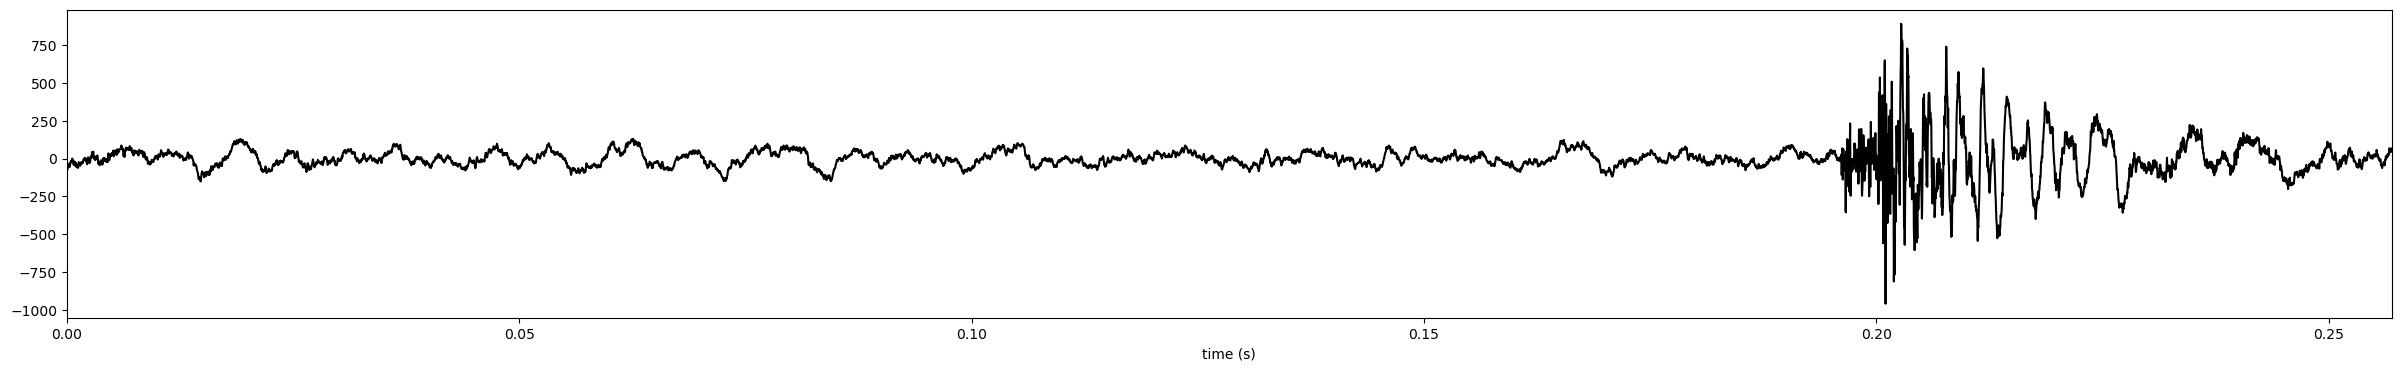

In [81]:
for audio in os.listdir('Dataset-custom-audio/base-audio'):
    if audio.endswith('.m4a'):
        m4a_file = 'Dataset-custom-audio\\base-audio\\'+audio
        wav_filename = 'Dataset-custom-audio\\base-audio\\'+audio.replace('.m4a','.wav')
        sound = AudioSegment.from_file(m4a_file, format='m4a')
        file_handle = sound.export(wav_filename, format='wav')
        os.remove(m4a_file) #TODO: change to "rename"
        continue
    audio=audio.replace('.wav','')
    print(audio)
    split_wav = SplitWavAudioMubin('Dataset-custom-audio/base-audio', 'Dataset-custom-audio/Split-audio/'+audio, audio)
    split_wav.split(min_len=9,thresh=1) #for reduced_noise: 9,1; for self.audio: 750, 0.05

#we graph the first chunk of the audio to check if it was split correctly
graphicMaker=GraphAudio()
graphicMaker.readFile('Dataset-custom-audio/Split-audio/0/0_0.wav')
graphicMaker.graph()

In [6]:
#TODO: remove audio files with silence only automatically

In [117]:
# Preprocessing

# Set the path to dataset folder
data_dir = 'Dataset-custom-audio/Split-audio'

# Load and preprocess audio data using spectrograms
#Label corresponds to folder names in Split-audio
labels = os.listdir(data_dir)
audio_data = []
target_labels = []

for label in labels:
	label_dir = data_dir + '/' + label
	# Iterate through each audio file in the respective folder
	for audio_file in os.listdir(label_dir):
		audio_path = os.path.join(label_dir, audio_file)
		y, sr = librosa.load(audio_path, duration=3) # Load audio and limit to 3 seconds
		spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
		spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
		# Transpose the spectrogram to have the shape (timesteps, n_mels)
		spectrogram = spectrogram.T
		audio_data.append(spectrogram)
		label=label.replace('audio_', '')
		target_labels.append(label)

c:\Users\Kat\.conda\envs\tesis\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=728
  warnings.warn(
c:\Users\Kat\.conda\envs\tesis\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=838
  warnings.warn(
c:\Users\Kat\.conda\envs\tesis\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=508
  warnings.warn(
c:\Users\Kat\.conda\envs\tesis\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=243
  warnings.warn(
c:\Users\Kat\.conda\envs\tesis\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(


In [118]:
# Encode target labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(target_labels)
 
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_data, encoded_labels, test_size=0.2, random_state=42)
 
# Ensure all spectrograms have the same shape
max_length = max([spec.shape[0] for spec in audio_data])
X_train = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in X_train]
X_test = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in X_test]
 
# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

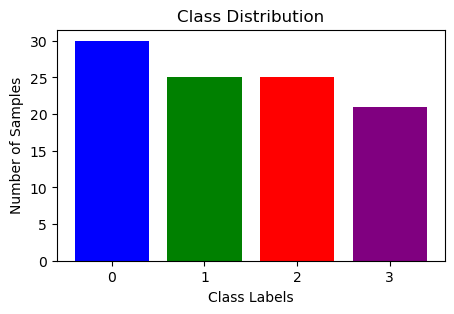

In [119]:
# Count the number of samples in each class
class_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in labels]
# Define colors for each class
class_colors = ['blue', 'green', 'red', 'purple']
# Create a bar chart to visualize class distribution
plt.figure(figsize=(5, 3))
plt.bar(labels, class_counts, color=class_colors)
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

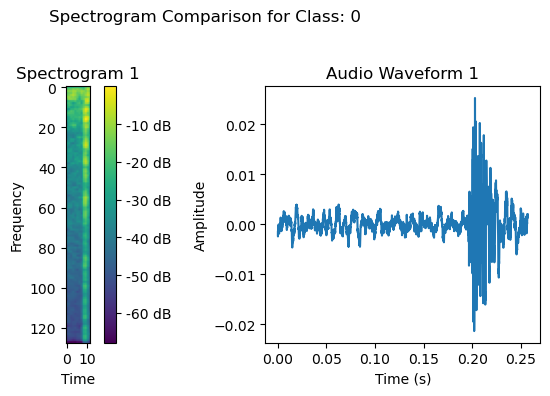

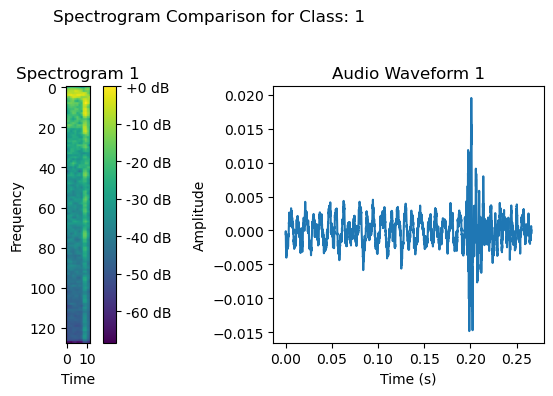

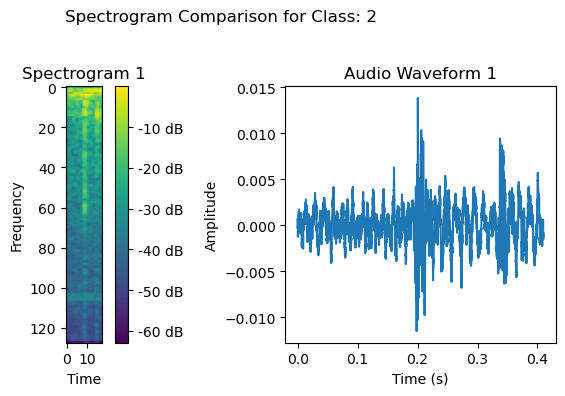

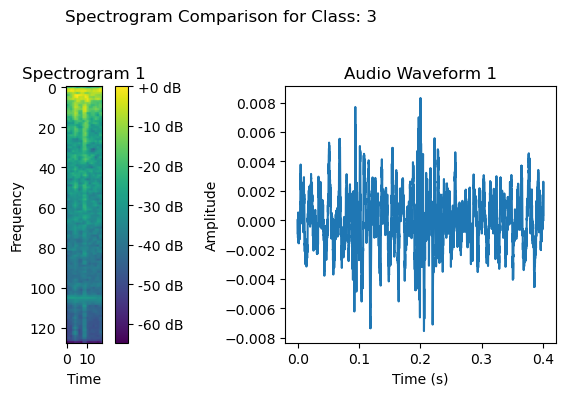

In [120]:
# Define a function to plot spectrograms for a class
def plot_spectrograms(label, num_samples=3):
    label_dir = os.path.join(data_dir, label)
    plt.figure(figsize=(7, 4))
    plt.suptitle(f"Spectrogram Comparison for Class: {label}")
 
    for i, audio_file in enumerate(os.listdir(label_dir)[:num_samples]):
        audio_path = os.path.join(label_dir, audio_file)
        y, sr = librosa.load(audio_path, duration=3)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
 
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title(f"Spectrogram {i + 1}")
        plt.imshow(spectrogram, cmap="viridis")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
 
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title(f"Audio Waveform {i + 1}")
        plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
 

# Visualize spectrograms and audio waveforms for "0" class
# adjust num_samples parameter to see desired number of  visualization of samples
unique_labels = np.unique(target_labels)

for label in unique_labels:
    plot_spectrograms(label, num_samples=1)
    print('\n')

In [121]:
# Convert the data to a flat 2D shape
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create Gradient Boosting classifier
model = GradientBoostingClassifier(random_state=42)
# Train the model
model.fit(X_train_flat, y_train)


GradientBoostingClassifier(random_state=42)

In [122]:
# Make predictions
y_pred = model.predict(X_test_flat)

# Results
print("Test values:")
print(y_test)
print("Prediction:")
print(y_pred)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("F1 score: {:.4f}".format(f1))

Test values:
[3 2 2 2 1 1 0 1 0 0 0 1 3 1 2 0 3 2 0 1 2]
Prediction:
[3 2 2 1 1 1 1 0 0 0 0 0 2 1 3 0 2 2 0 2 2]
Accuracy: 0.6190
F1 score: 0.6086


In [124]:
# For splitting audio for testing purposes.
# only run to generate new audio files.
for audio in os.listdir('Dataset-custom-audio/test-audio-not-split'): #in test-audio-not-split add the .m4a or .wav file to be used
    if audio.endswith('.m4a'):
        m4a_file = 'Dataset-custom-audio\\test-audio-not-split\\'+audio
        wav_filename = 'Dataset-custom-audio\\test-audio-not-split\\'+audio.replace('.m4a','.wav')
        sound = AudioSegment.from_file(m4a_file, format='m4a')
        file_handle = sound.export(wav_filename, format='wav')
        os.remove(m4a_file) #TODO: change to "rename"
        continue
    audio=audio.replace('.wav','')
    print(audio)
    split_wav = SplitWavAudioMubin('Dataset-custom-audio/test-audio-not-split', 'Dataset-custom-audio/test-audio', audio)
    split_wav.split(min_len=33,thresh=.9) #adjust this accordingly until desired amount of keys obtained

010123
Dataset-custom-audio/test-audio-not-split/010123.wav
audio to predict: Dataset-custom-audio/test-audio-not-split/010123.wav
dbfs: -47.08163865449485
Number of chunks detected: 6
export path:Dataset-custom-audio/test-audio/010123_
appended chunk 0
appended chunk 1
appended chunk 2
appended chunk 3
appended chunk 4
appended chunk 5
split successfully for: 010123 with 6 samples


In [125]:
#Prediction with custom audio

#Preparing audio for prediction; audio should already be split by letter 

# Set the path to dataset folder
data_dir_test = 'Dataset-custom-audio/test-audio'

# Load and preprocess audio data using spectrograms
#Label corresponds to folder names in test-audio
labels_test = os.listdir(data_dir_test)
audio_data_test = []
target_labels_test = []

for label in labels_test:
	label_dir = data_dir_test + '/' + label
	y, sr = librosa.load(label_dir, duration=3) # Load audio and limit to 3 seconds
	spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
	spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
	# Transpose the spectrogram to have the shape (timesteps, n_mels)
	spectrogram = spectrogram.T
	audio_data_test.append(spectrogram)
	label=label.replace('audio_', '')
	target_labels_test.append(label)

In [126]:
def get_alphabet_position(char):
    char = char.lower()  # Convert the character to lowercase
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    position = alphabet.index(char) + 1
    return position

In [128]:
print(target_labels_test)

# Encode target labels
codeword=['0','1','0','1','2','3'] #recorded text separated by character :)
encoded_labels_test = []
for label in codeword:
    if int(label)>9:
        position=get_alphabet_position(label)+9
        encoded_labels_test.append(position)
    else:
        encoded_labels_test.append(int(label))

# Ensure all spectrograms have the same shape
max_length = max([spec.shape[0] for spec in audio_data])
data_for_test = [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in audio_data_test]
 
# Convert to NumPy arrays
data_for_test = np.array(data_for_test)

['010123_0.wav', '010123_1.wav', '010123_2.wav', '010123_3.wav', '010123_4.wav', '010123_5.wav']


In [129]:
# Convert the data to a flat 2D shape
data_for_test_flat = data_for_test.reshape(data_for_test.shape[0], -1)

# Make predictions
y_pred_test = model.predict(data_for_test_flat)

# Results
print("Test values:")
print(encoded_labels_test)
print("Prediction:")
print(y_pred_test)

# Calculate accuracy and F1 score
accuracy_test = accuracy_score(encoded_labels_test, y_pred_test)
f1_test = f1_score(encoded_labels_test, y_pred_test, average='weighted')

print("Accuracy: {:.4f}".format(accuracy_test))
print("F1 score: {:.4f}".format(f1_test))


Test values:
[0, 1, 0, 1, 2, 3]
Prediction:
[3 3 3 1 1 1]
Accuracy: 0.1667
F1 score: 0.1333
